In [1]:
%matplotlib inline

In [113]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import pickle

import mlflow

from sklearn.model_selection import train_test_split, RandomizedSearchCV

from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import MaxAbsScaler

from sklearn.decomposition import TruncatedSVD

from sklearn.linear_model import SGDClassifier

from sklearn.metrics import classification_report, roc_auc_score

# Machine Learning in Production

Dataset sourcs: https://www.kaggle.com/code/ayhampar/spam-ham-dataset

In [3]:
emails = pd.read_csv("data/spam_ham_dataset.csv")

In [5]:
emails = emails.drop(columns = ["Unnamed: 0"])

In [6]:
emails

,label,text,label_num
0,ham,Subject: enron methanol ; meter # : 988291\r\n...,0
1,ham,"Subject: hpl nom for january 9 , 2001\r\n( see...",0
2,ham,"Subject: neon retreat\r\nho ho ho , we ' re ar...",0
3,spam,"Subject: photoshop , windows , office . cheap ...",1
4,ham,Subject: re : indian springs\r\nthis deal is t...,0
...,...,...,...
5166,ham,Subject: put the 10 on the ft\r\nthe transport...,0
5167,ham,Subject: 3 / 4 / 2000 and following noms\r\nhp...,0
5168,ham,Subject: calpine daily gas nomination\r\n>\r\n...,0
5169,ham,Subject: industrial worksheets for august 2000...,0


In [7]:
emails.dtypes

label        object
text         object
label_num     int64
dtype: object

In [8]:
emails.to_csv("data/emails_cleaned.csv", index = None)

In [10]:
emails.label.value_counts()

label
ham     3672
spam    1499
Name: count, dtype: int64

In [11]:
emails.label.value_counts(normalize = True)

label
ham     0.710114
spam    0.289886
Name: proportion, dtype: float64

In [25]:
emails_train, emails_test, labels_train, labels_test = train_test_split(
    emails.drop(columns = "label"), 
    emails.label,
    stratify = emails.label,
    random_state = 42,
    test_size = 0.2
)

In [26]:
emails.text.str.len()

0        327
1         97
2       2524
3        414
4        336
        ... 
5166     534
5167    1114
5168     402
5169     573
5170    1114
Name: text, Length: 5171, dtype: int64

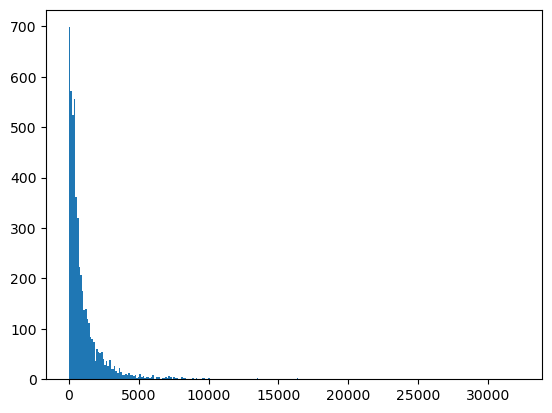

In [27]:
plt.hist(emails.text.str.len(), bins = "fd")
plt.show()

In [28]:
emails[emails.text.str.len() > 30000]

,label,text,label_num
949,ham,"Subject: fw : "" red , white and blue out ""\r\n...",0


In [29]:
# emails[emails.text.str.len() > 30000].text.values[0] # sent to many email addresses

In [30]:
# print(emails[emails.text.str.len() > 30000].text.values[0])

In [33]:
pd.concat([emails_train, labels_train], axis = 1).to_csv("data/train.csv")

In [34]:
pd.concat([emails_test, labels_test], axis = 1).to_csv("data/test.csv")

In [39]:
TfidfVectorizer().fit_transform(emails_train.text)

<4136x43788 sparse matrix of type '<class 'numpy.float64'>'
	with 365097 stored elements in Compressed Sparse Row format>

In [71]:
model_pipeline = Pipeline(
    [
        ("tfidf", TfidfVectorizer()), # ngram_range = (1, 2)
        ("scaler", MaxAbsScaler()),
        ("svd", TruncatedSVD(n_components = 150)),
        ("sgd", SGDClassifier(loss = "hinge")),
    ]
)

In [72]:
model_pipeline.fit(emails_train.text, labels_train)

Pipeline(steps=[('tfidf', TfidfVectorizer()), ('scaler', MaxAbsScaler()),
                ('svd', TruncatedSVD(n_components=150)),
                ('sgd', SGDClassifier())])

In [73]:
model_pipeline.steps

[('tfidf', TfidfVectorizer()),
 ('scaler', MaxAbsScaler()),
 ('svd', TruncatedSVD(n_components=150)),
 ('sgd', SGDClassifier())]

In [74]:
model_pipeline.predict(emails_train.text)

array(['spam', 'spam', 'ham', ..., 'ham', 'ham', 'ham'], dtype='<U4')

In [75]:
len(model_pipeline["tfidf"].vocabulary_)

43788

In [78]:
print(classification_report(labels_train, model_pipeline.predict(emails_train.text)))

              precision    recall  f1-score   support

         ham       0.99      0.97      0.98      2937
        spam       0.92      0.98      0.95      1199

    accuracy                           0.97      4136
   macro avg       0.96      0.98      0.97      4136
weighted avg       0.97      0.97      0.97      4136



In [79]:
print(classification_report(labels_test, model_pipeline.predict(emails_test.text)))

              precision    recall  f1-score   support

         ham       0.99      0.97      0.98       735
        spam       0.93      0.98      0.95       300

    accuracy                           0.97      1035
   macro avg       0.96      0.98      0.97      1035
weighted avg       0.97      0.97      0.97      1035



TruncatedSVD(n_components = 2)

In [80]:
model_pipeline_2 = Pipeline(
    [
        ("tfidf", TfidfVectorizer()), # ngram_range = (1, 2)
        ("scaler", MaxAbsScaler()),
        ("svd", TruncatedSVD(n_components = 2)),
        ("sgd", SGDClassifier(loss = "hinge")),
    ]
)

In [81]:
model_pipeline_2.fit(emails_train.text, labels_train)

Pipeline(steps=[('tfidf', TfidfVectorizer()), ('scaler', MaxAbsScaler()),
                ('svd', TruncatedSVD()), ('sgd', SGDClassifier())])

In [82]:
model_pipeline_2.steps

[('tfidf', TfidfVectorizer()),
 ('scaler', MaxAbsScaler()),
 ('svd', TruncatedSVD()),
 ('sgd', SGDClassifier())]

In [83]:
model_pipeline_2.predict(emails_train.text)

array(['spam', 'spam', 'ham', ..., 'ham', 'ham', 'ham'], dtype='<U4')

In [85]:
print(classification_report(labels_train, model_pipeline_2.predict(emails_train.text)))

              precision    recall  f1-score   support

         ham       0.97      0.93      0.95      2937
        spam       0.85      0.93      0.89      1199

    accuracy                           0.93      4136
   macro avg       0.91      0.93      0.92      4136
weighted avg       0.93      0.93      0.93      4136



In [86]:
print(classification_report(labels_test, model_pipeline_2.predict(emails_test.text)))

              precision    recall  f1-score   support

         ham       0.96      0.93      0.94       735
        spam       0.84      0.90      0.87       300

    accuracy                           0.92      1035
   macro avg       0.90      0.92      0.91      1035
weighted avg       0.92      0.92      0.92      1035



__Optimized model__

In [94]:
model_pipeline_opt = Pipeline(
    [
        ("tfidf", TfidfVectorizer()), 
        ("scaler", MaxAbsScaler()),
        ("svd", TruncatedSVD()),
        ("sgd", SGDClassifier()),
    ]
)

In [95]:
tuner = RandomizedSearchCV(model_pipeline_opt, param_distributions = {
    "tfidf__ngram_range": [(1, 2), (1, 3)],
    "svd__n_components": [3, 10, 100, 150, 200]
    }, n_iter = 5, verbose = 3
)

In [96]:
tuner.fit(emails_train.text, labels_train)

Fitting 5 folds for each of 5 candidates, totalling 25 fits
[CV 1/5] END svd__n_components=10, tfidf__ngram_range=(1, 2);, score=0.896 total time=   2.2s
[CV 2/5] END svd__n_components=10, tfidf__ngram_range=(1, 2);, score=0.919 total time=   2.0s
[CV 3/5] END svd__n_components=10, tfidf__ngram_range=(1, 2);, score=0.894 total time=   2.0s
[CV 4/5] END svd__n_components=10, tfidf__ngram_range=(1, 2);, score=0.902 total time=   2.0s
[CV 5/5] END svd__n_components=10, tfidf__ngram_range=(1, 2);, score=0.896 total time=   2.0s
[CV 1/5] END svd__n_components=100, tfidf__ngram_range=(1, 3);, score=0.940 total time=  17.3s
[CV 2/5] END svd__n_components=100, tfidf__ngram_range=(1, 3);, score=0.938 total time=  20.8s
[CV 3/5] END svd__n_components=100, tfidf__ngram_range=(1, 3);, score=0.942 total time=  16.9s
[CV 4/5] END svd__n_components=100, tfidf__ngram_range=(1, 3);, score=0.950 total time=  20.2s
[CV 5/5] END svd__n_components=100, tfidf__ngram_range=(1, 3);, score=0.937 total time=  1

RandomizedSearchCV(estimator=Pipeline(steps=[('tfidf', TfidfVectorizer()),
                                             ('scaler', MaxAbsScaler()),
                                             ('svd', TruncatedSVD()),
                                             ('sgd', SGDClassifier())]),
                   n_iter=5,
                   param_distributions={'svd__n_components': [3, 10, 100, 150,
                                                              200],
                                        'tfidf__ngram_range': [(1, 2), (1, 3)]},
                   verbose=3)

In [100]:
tuner.best_params_

{'tfidf__ngram_range': (1, 2), 'svd__n_components': 100}

In [102]:
best_pipeline = tuner.best_estimator_

# MLflow experiments

In [104]:
mlflow.create_experiment("Dimentionality reduction + SGD")

'839435082656377788'

In [105]:
mlflow.get_experiment_by_name("Dimentionality reduction + SGD")

<Experiment: artifact_location='file:///C:/Users/diton/Machine_Learning/10-ML-in-Production/mlruns/839435082656377788', creation_time=1732976879587, experiment_id='839435082656377788', last_update_time=1732976879587, lifecycle_stage='active', name='Dimentionality reduction + SGD', tags={}>

In [ ]:
# experiment_name = "Dimentionality reduction + SGD"
# experiment = mlflow.get_experiment_by_name("Dimentionality reduction + SGD")
# if not experiment:
#     mlflow.create_experiment(experiment_name)

In [106]:
experiment = mlflow.get_experiment_by_name("Dimentionality reduction + SGD")

In [107]:
mlflow.set_experiment("Dimentionality reduction + SGD")

<Experiment: artifact_location='file:///C:/Users/diton/Machine_Learning/10-ML-in-Production/mlruns/839435082656377788', creation_time=1732976879587, experiment_id='839435082656377788', last_update_time=1732976879587, lifecycle_stage='active', name='Dimentionality reduction + SGD', tags={}>

In [108]:
with mlflow.start_run(run_name = "Initial check"):
    mlflow.log_param("train size", len(labels_train))
    mlflow.log_param("test size", len(labels_test))
    mlflow.log_param("stratification", True) # stratify is not None

In [109]:
with mlflow.start_run(run_name = "Training dry-run"):
    mlflow.log_param("train size", len(labels_train))
    mlflow.log_param("test size", len(labels_test))
    mlflow.log_param("stratification", True)

    model_pipeline.fit(emails_train.text, labels_train)

    mlflow.log_param("vocabulary size", len(model_pipeline["tfidf"].vocabulary_))

    mlflow.log_metric("train_accuracy", model_pipeline.score(emails_train.text, labels_train))
    mlflow.log_metric("test_accuracy", model_pipeline.score(emails_test.text, labels_test))

In [111]:
with mlflow.start_run(run_name = "Training dry-run 2"):
    mlflow.log_param("train size", len(labels_train))
    mlflow.log_param("test size", len(labels_test))
    mlflow.log_param("stratification", True)

    model_pipeline.fit(emails_train.text, labels_train)

    mlflow.log_param("vocabulary size", len(model_pipeline["tfidf"].vocabulary_))
    mlflow.log_param("SVD n_components", model_pipeline["svd"].n_components)
    

    mlflow.log_metric("train_accuracy", model_pipeline.score(emails_train.text, labels_train))
    mlflow.log_metric("test_accuracy", model_pipeline.score(emails_test.text, labels_test))

In [112]:
with mlflow.start_run(run_name = "Less SVD components"):
    mlflow.log_param("train size", len(labels_train))
    mlflow.log_param("test size", len(labels_test))
    mlflow.log_param("stratification", True)
    
    model_pipeline["svd"].n_components = 2
    model_pipeline.fit(emails_train.text, labels_train)

    mlflow.log_param("vocabulary size", len(model_pipeline["tfidf"].vocabulary_))
    mlflow.log_param("SVD n_components", model_pipeline["svd"].n_components)
    

    mlflow.log_metric("train_accuracy", model_pipeline.score(emails_train.text, labels_train))
    mlflow.log_metric("test_accuracy", model_pipeline.score(emails_test.text, labels_test))

In [117]:
with mlflow.start_run(run_name = "Best parameters"):
    mlflow.log_param("train size", len(labels_train))
    mlflow.log_param("test size", len(labels_test))
    mlflow.log_param("stratification", True)

    best_pipeline.fit(emails_train.text, labels_train)

    mlflow.log_param("vocabulary size", len(best_pipeline["tfidf"].vocabulary_))
    mlflow.log_param("SVD n_components", best_pipeline["svd"].n_components)
    

    mlflow.log_metric("train_accuracy", best_pipeline.score(emails_train.text, labels_train))
    mlflow.log_metric("test_accuracy", best_pipeline.score(emails_test.text, labels_test))

    pickle.dump(best_pipeline, open("model.pkl", "wb"))

    with open("train_report.txt", "w") as f:
        f.write(classification_report(labels_train, best_pipeline.predict(emails_train.text)))

    with open("test_report.txt", "w") as f:
        f.write(classification_report(labels_test, best_pipeline.predict(emails_test.text)))

    mlflow.log_artifact("model.pkl")
    mlflow.log_artifact("train_report.txt")
    mlflow.log_artifact("test_report.txt")

In [127]:
emails_train.sample().text.values[0]

'Subject: enron / hpl actuals for july 11 , 2000\r\nteco tap 10 . 000 / enron ; 75 . 000 / hpl iferc\r\nls hpl lsk ic 30 . 000 / enron'